In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content
!unzip /content/drive/'My Drive'/ML/darknet.zip

In [ ]:
%cd /content/darknet
!sudo apt install dos2unix
!dos2unix cfg/yolov3.cfg train.txt val.txt yolo.names yolo.data

In [ ]:
#check cuda version
!/usr/local/cuda/bin/nvcc --version

In [ ]:
#translate file
!find . -type f | xargs -n 5 touch
!make clean
!make

In [6]:
#backup to drive
!rm /content/darknet/backup -r
!ln -s /content/drive/'My Drive'/ML/backup /content/darknet

In [ ]:
#train data
%cd /content/darknet
!./darknet detector train yolo.data cfg/yolov3.cfg darknet53.conv.74

In [8]:
#train continue weights
%cd /content/darknet
!./darknet detector train yolo.data cfg/yolov3.cfg backup/yolov3_800.weights

/content/darknet
yolov3
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    

In [ ]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt

img = cv2.imread("/content/darknet/data/images/24.jpg")

width = img.shape[1]
height = img.shape[0]
yolo_w = 416
yolo_h = 416
VEHICLE_CLASSES = [1, 2]

classes = ["math", "image", "table", "text"]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNetFromDarknet("/content/darknet/cfg/yolov3.cfg", "/content/drive/MyDrive/ML/backup/yolov3.backup")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1/255.0, (yolo_w, yolo_h), swapRB=True, crop=False)

net.setInput(blob)

outputs = net.forward(ln)

for out in outputs:
    print(out.shape)

boxes = []
class_ids = []
confidences = []

for out in outputs:
  for detection in out:
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.6:
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)
        class_ids.append(class_id)
        confidences.append(float(confidence))
        boxes.append([x, y, w, h])

In [ ]:
len(boxes)

13

In [ ]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
font = cv2.FONT_HERSHEY_PLAIN

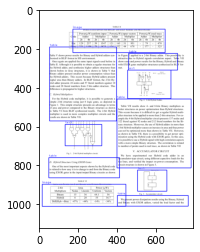

In [ ]:

for i in range(len(boxes)):
	if i in indexes.flatten():
		x, y, w, h = boxes[i]
		label = str(classes[class_ids[i]])
		cv2.rectangle(img, (x,y), (x+w, y+h), (0, 0, 255), 2)
		cv2.putText(img, label, (x, y - 5), font, 1, (0, 0, 255), 1)

plt.imshow(img)
plt.show()